In [25]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
import pandas as pd
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)

In [26]:
import pandas as pd
from nltk import FreqDist
def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result

In [27]:
# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

In [28]:
# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

In [29]:
# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]

df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]

In [30]:
shareTrend = {'tagName' : df_share['index'], 'preGPT': df_share.iloc[:, 641:731].mean(axis = 1, skipna=True),
              'postGPT' : df_share.iloc[:, 731:].mean(axis = 1, skipna=True)}
shareTrend = pd.DataFrame(shareTrend)

In [31]:
# Convert nan to 0
shareTrend.fillna(0, inplace = True)
shareTrend['diff'] = shareTrend['postGPT'] - shareTrend['preGPT']

In [32]:
shareTrend.sort_values('diff', ascending = False)

,tagName,preGPT,postGPT,diff
242,nextDOTjs,0.287568,0.452411,0.164843
442,springboot,0.425927,0.546275,0.120348
168,seleniumwebdriver,0.097958,0.218038,0.120081
29,angular,0.495756,0.557043,0.061287
51952,boomerangapp,0.000000,0.053050,0.053050
...,...,...,...,...
149,dataframe,0.563057,0.401511,-0.161546
28,arrays,0.578478,0.361360,-0.217118
72,pandas,0.929865,0.647534,-0.282331
5,javascript,3.548633,3.055816,-0.492817


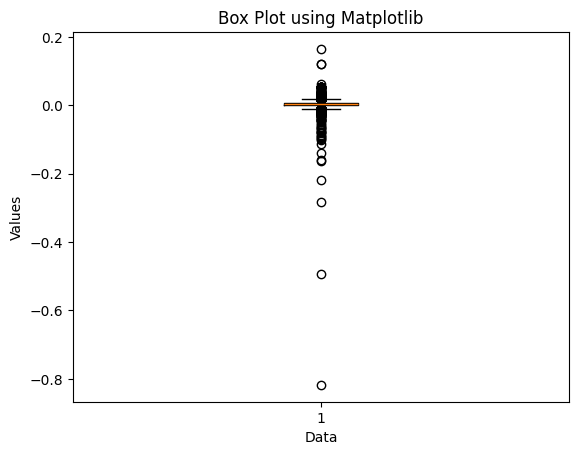

In [33]:
# Create a box plot
plt.boxplot(shareTrend['diff'])
plt.title('Box Plot using Matplotlib')
plt.xlabel('Data')
plt.ylabel('Values')
plt.show()

In [34]:
shareTrend[shareTrend['diff'] < -.8]

,tagName,preGPT,postGPT,diff
17,python,5.378989,4.561351,-0.817638


In [35]:
len(shareTrend)

51953

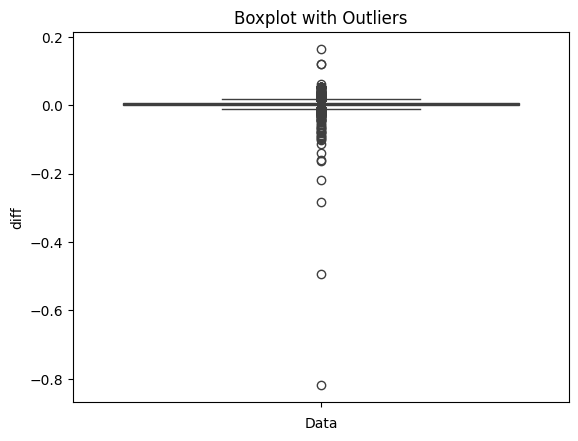

In [36]:
# Generate sample data with some random outliers
import seaborn as sns

# Create the boxplot
sns.boxplot(data=shareTrend['diff'])
plt.title("Boxplot with Outliers")
plt.xlabel("Data")
plt.show()

# Identify outliers
q1 = np.percentile(shareTrend['diff'], 25)
q3 = np.percentile(shareTrend['diff'], 75)
iqr = q3 - q1

# Outlier cutoffs
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter data for outliers
outliers = shareTrend[(shareTrend['diff'] < lower_bound) | (shareTrend['diff'] > upper_bound)]
outliers

cleaned_data = shareTrend[(shareTrend['diff'] >= lower_bound) & (shareTrend['diff'] <= upper_bound)]

In [37]:
print(len(outliers))
print(len(cleaned_data))

1107
50846


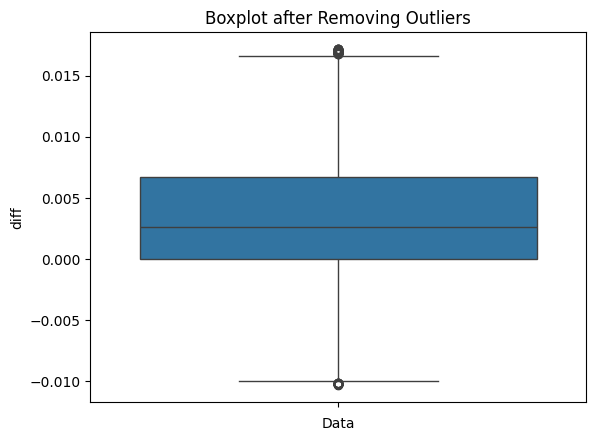

In [14]:
# Create the boxplot for the cleaned data
sns.boxplot(data=cleaned_data['diff'])
plt.title("Boxplot after Removing Outliers")
plt.xlabel("Data")
plt.show()

### Model with cleansed data

In [15]:
cleaned_data

,tagName,preGPT,postGPT,diff
2,foreach,0.029891,0.024514,-0.005376
3,terraform,0.096611,0.100607,0.003996
4,awsglue,0.021343,0.028133,0.006790
6,lambda,0.042614,0.035909,-0.006706
7,prolog,0.017217,0.017763,0.000546
...,...,...,...,...
51939,commercekickstart,0.000000,0.016650,0.016650
51940,pcalg,0.000000,0.016650,0.016650
51941,graphqlrequest,0.000000,0.016650,0.016650
51942,apq,0.000000,0.016650,0.016650


In [16]:
cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)

In [17]:
cleansed

,index,tag,tag_2020_11_30,tagShare_2020_11_30,tag_2020_12_01,tagShare_2020_12_01,tag_2020_12_02,tagShare_2020_12_02,tag_2020_12_03,tagShare_2020_12_03,...,tag_2023_08_30,tagShare_2023_08_30,tag_2023_08_31,tagShare_2023_08_31,tag_2023_09_01,tagShare_2023_09_01,tag_2023_09_02,tagShare_2023_09_02,tag_2023_09_03,tagShare_2023_09_03
0,foreach,3614,9.0,0.060386,5.0,0.031256,3.0,0.018553,6.0,0.034441,...,3.0,0.026112,2.0,0.017680,1.0,0.010256,1.0,0.01665,NaN,NaN
1,terraform,11491,13.0,0.087225,12.0,0.075014,10.0,0.061843,8.0,0.045922,...,13.0,0.113152,17.0,0.150283,13.0,0.133333,2.0,0.03330,NaN,NaN
2,awsglue,2203,3.0,0.020129,5.0,0.031256,2.0,0.012369,1.0,0.005740,...,2.0,0.017408,NaN,NaN,2.0,0.020513,NaN,NaN,NaN,NaN
3,lambda,4718,4.0,0.026838,6.0,0.037507,3.0,0.018553,5.0,0.028701,...,6.0,0.052224,8.0,0.070721,2.0,0.020513,2.0,0.03330,1.0,0.05305
4,prolog,1775,5.0,0.033548,10.0,0.062512,4.0,0.024737,3.0,0.017221,...,2.0,0.017408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50841,commercekickstart,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.01665,NaN,NaN
50842,pcalg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.01665,NaN,NaN
50843,graphqlrequest,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.01665,NaN,NaN
50844,apq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.01665,NaN,NaN


### 2) Calculate HHI Index

In [18]:
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result
# Measure score
HHI_Score = []
# Calculate HHI for each monthly tag share column.
for i in range(3, cleansed.shape[1], 2):
    HHI_Score.append(square_sum(cleansed.iloc[:, i]))
result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

In [19]:
result_HHI

,year_month,HHI_Score
0,2020-11-30,5.854880
1,2020-12-01,5.561382
2,2020-12-02,5.735902
3,2020-12-03,5.393797
4,2020-12-04,5.747784
...,...,...
1003,2023-08-30,5.773838
1004,2023-08-31,5.824259
1005,2023-09-01,5.810703
1006,2023-09-02,6.890933


### 3) Diff-in-Diff
- Treated Group : 2022-09 ~ 2023-08 (12 months)
- Control Group : 2021-09 ~ 2022-08 (12 months)
- Diversity Ratio == HHI_Score

In [129]:
hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
           (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
# Split Data
control_data = pd.DataFrame({'HHI' : hhi[:365],
              'T_d': [0]*len(hhi[:365]),
              'P_t' : [0]*90 + [1]*275})
treated_data = pd.DataFrame({'HHI' : hhi[365:],
              'T_d': [1]*len(hhi[365:]),
              'P_t' : [0]*90 + [1]*275})
df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
# Add date and month feature
df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
           (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
df_did['month'] = pd.to_datetime(df_did['date']).dt.month
# Apply log
df_did['ln_y'] = np.log(df_did['HHI'])

### 4) Model Fitting

In [130]:
sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8023,0.053,34.050,0.000,1.698,1.906
C(month)[T.2],0.0032,0.013,0.241,0.809,-0.023,0.029
C(month)[T.3],0.0057,0.013,0.440,0.660,-0.020,0.031
C(month)[T.4],-0.0196,0.013,-1.504,0.133,-0.045,0.006
C(month)[T.5],0.0251,0.013,1.940,0.053,-0.000,0.051
C(month)[T.6],0.0369,0.013,2.824,0.005,0.011,0.063
C(month)[T.7],0.0642,0.013,4.954,0.000,0.039,0.090
C(month)[T.8],0.0821,0.013,6.341,0.000,0.057,0.108
C(month)[T.9],0.0246,0.053,0.460,0.646,-0.080,0.130
C(month)[T.10],0.0078,0.053,0.145,0.885,-0.097,0.113


In [131]:
sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ln_y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     13.74
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           2.96e-29
Time:                        16:34:37   Log-Likelihood:                 891.43
No. Observations:                 730   AIC:                            -1753.
Df Residuals:                     715   BIC:                            -1684.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.8023      0.053     34.050      0.000       1.698       1.906
C(month)[T.2]      0.0032      0.013      0.241      0.809      -0.023       0.029
C(month)[T.3]      0.0057      0.013      0.440      0.660      -0.020       0.031
C(month)[T.4]     -0.0196      0.013     -1.504      0.133      -0.045       0.006
C(month)[T.5]      0.0251      0.013      1.940      0.053      -0.000       0.051
C(month)[T.6]      0.0369      0.013      2.824      0.005       0.011       0.063
C(month)[T.7]      0.0642      0.013      4.954      0.000       0.039       0.090
C(month)[T.8]      0.0821      0.013      6.341      0.000       0.057       0.108
C(month)[T.9]      0.0246      0.053      0.460      0.646      -0.080       0.130
C(month)[T.10]     0.0078      0.053      0.145      0.885      -0.097       0.113
C(month)[T.11]    -0.0006      0.052     -0.011      0.991      -0.102       0.101
C(month)[T.12]    -0.0286      0.013     -2.209      0.028      -0.054      -0.003
T_d               -0.0029      0.011     -0.273      0.785      -0.024       0.018
P_t                0.0432      0.052      0.827      0.409      -0.059       0.146
T_d:P_t           -0.0137      0.012     -1.104      0.270      -0.038       0.011
==============================================================================
Omnibus:                        2.812   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.784
Skew:                          -0.086   Prob(JB):                        0.249
Kurtosis:                       3.249   Cond. No.                         65.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Alternative
- only consider diff score lower than -0.4 as outliers

In [20]:
cleaned_data = shareTrend[(shareTrend['diff'] >= -0.4)]
cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result
# Measure score
HHI_Score = []
# Calculate HHI for each monthly tag share column.
for i in range(3, cleansed.shape[1], 2):
    HHI_Score.append(square_sum(cleansed.iloc[:, i]))
result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
           (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
# Split Data
control_data = pd.DataFrame({'HHI' : hhi[:365],
              'T_d': [0]*len(hhi[:365]),
              'P_t' : [0]*90 + [1]*275})
treated_data = pd.DataFrame({'HHI' : hhi[365:],
              'T_d': [1]*len(hhi[365:]),
              'P_t' : [0]*90 + [1]*275})
df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
# Add date and month feature
df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
           (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
df_did['month'] = pd.to_datetime(df_did['date']).dt.month
# Apply log
df_did['ln_y'] = np.log(df_did['HHI'])

In [133]:
sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.4599,0.047,73.671,0.000,3.368,3.552
C(month)[T.2],-0.0195,0.012,-1.652,0.099,-0.043,0.004
C(month)[T.3],-0.0186,0.011,-1.623,0.105,-0.041,0.004
C(month)[T.4],-0.0031,0.012,-0.268,0.789,-0.026,0.020
C(month)[T.5],-0.0028,0.011,-0.248,0.804,-0.025,0.020
C(month)[T.6],-0.0224,0.012,-1.931,0.054,-0.045,0.000
C(month)[T.7],-0.0235,0.011,-2.045,0.041,-0.046,-0.001
C(month)[T.8],-0.0360,0.011,-3.131,0.002,-0.059,-0.013
C(month)[T.9],-0.0017,0.047,-0.037,0.971,-0.095,0.091
C(month)[T.10],-0.0161,0.047,-0.339,0.735,-0.109,0.077


In [134]:
sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   ln_y   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     84.99
Date:                Wed, 17 Apr 2024   Prob (F-statistic):          1.36e-141
Time:                        16:35:00   Log-Likelihood:                 978.74
No. Observations:                 730   AIC:                            -1927.
Df Residuals:                     715   BIC:                            -1859.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4599      0.047     73.671      0.000       3.368       3.552
C(month)[T.2]     -0.0195      0.012     -1.652      0.099      -0.043       0.004
C(month)[T.3]     -0.0186      0.011     -1.623      0.105      -0.041       0.004
C(month)[T.4]     -0.0031      0.012     -0.268      0.789      -0.026       0.020
C(month)[T.5]     -0.0028      0.011     -0.248      0.804      -0.025       0.020
C(month)[T.6]     -0.0224      0.012     -1.931      0.054      -0.045       0.000
C(month)[T.7]     -0.0235      0.011     -2.045      0.041      -0.046      -0.001
C(month)[T.8]     -0.0360      0.011     -3.131      0.002      -0.059      -0.013
C(month)[T.9]     -0.0017      0.047     -0.037      0.971      -0.095       0.091
C(month)[T.10]    -0.0161      0.047     -0.339      0.735      -0.109       0.077
C(month)[T.11]    -0.0424      0.046     -0.922      0.357      -0.133       0.048
C(month)[T.12]     0.0173      0.011      1.509      0.132      -0.005       0.040
T_d               -0.1001      0.010    -10.492      0.000      -0.119      -0.081
P_t               -0.0175      0.046     -0.378      0.705      -0.108       0.073
T_d:P_t           -0.0698      0.011     -6.354      0.000      -0.091      -0.048
==============================================================================
Omnibus:                       55.184   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.643
Skew:                           0.736   Prob(JB):                     3.38e-15
Kurtosis:                       2.853   Cond. No.                         65.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Aditional Figures

In [ ]:
import plotly.express as px


# Create an interactive box plot
fig = px.box(shareTrend['diff'], points="all", title="Avg. Tag Share Comparison (PreGPT Vs. PostGPT)",
             hover_data = [shareTrend['tagName']])
fig.update_layout(height=600)


# Show the plot
fig.show()

In [22]:
df_count.columns.get_loc('tag_2022_11_30')

731

In [24]:
df_count.columns.get_loc('tag_2023_09_03')

1008

In [23]:
1009-731

278

In [ ]:
# tag_2020_11_30 -> tag2023_09_03
# release of chatGPT -> November 30, 2022

In [9]:
all_keys

,index,tag
0,amazonwebservices,52132
1,forloop,16939
2,foreach,3614
3,terraform,11491
4,awsglue,2203
...,...,...
51948,applespeech,1
51949,jsonloader,1
51950,livescript,1
51951,nxhtml,1


In [ ]:
# 변동폭이 높았던 순으로 나열
# 3개 정도의 partion으로 자르기.
# 각각의 partition에 대해 DiD 계산.